In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
imgSize = 170

# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Test/Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [4]:
trainpath = '/kaggle/input/train'
testPath = '/kaggle/input/test'

trainData = datasets.ImageFolder(root = trainpath, transform = transformer)
testData = datasets.ImageFolder(root = testPath, transform = valTransformer)

In [5]:
len(trainData)

11879

In [6]:
# Define the sizes of each split
total_samples = len(trainData)
train_size = int(0.9 * total_samples)
val_size = total_samples - train_size

# Split the dataset
trainData, valData = torch.utils.data.random_split(trainData, [train_size, val_size])

In [7]:
# Data loaders
batchSize = 16

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)
testLoader = DataLoader(testData, batch_size = batchSize, shuffle = False, num_workers = 4)

In [8]:
# We visualize a dataloader.
train_data, train_label = next(iter(trainLoader))

train_data.shape, train_label.shape

(torch.Size([16, 3, 170, 170]), torch.Size([16]))

In [9]:
# Using a pre-trained EfficientNetV2L model
model = models.efficientnet_b7(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 168MB/s]


In [11]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [12]:
# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

In [13]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [14]:
import torch
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0,
                 restore_best_weights=True, path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        self.path = path
        self.early_stop = False

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

    def __call__(self, model, val_loss):
        
#         self.save_checkpoint(model)
        
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                    self.save_checkpoint(model)
                self.early_stop = True
                return True
        return False

In [15]:
# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, min_delta = 0.0)

In [16]:
from tqdm.autonotebook import tqdm

# Build a train step

In [17]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)
    
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        
        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y)
        train_loss += loss.detach().cpu().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_proba = torch.sigmoid(y_pred)
        accuracy_train.update(y_proba, y)
        
    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)
    
#     print(type(train_loss))
#     print(type(train_accuracy))
    
    return train_loss, train_accuracy

# Build a Val step

In [18]:
def val_step(model:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader, 
              loss_fn:torch.nn.Module):
    
    model.eval()
    
    val_loss = 0.
    accuracy_val = BinaryAccuracy(threshold = 0.5).to(device)
    
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)
        
        y_pred = model(X).squeeze()
        
        loss = loss_fn(y_pred, y)
        val_loss += loss.detach().cpu().item()
        
        y_proba = torch.sigmoid(y_pred)
        accuracy_val.update(y_proba, y)
        
    val_accuracy = accuracy_val.compute()
    val_loss = val_loss/len(dataloader)
#     print(type(test_loss))
#     print(type(test_accuracy))
    
    return val_loss, val_accuracy

# Build a training loop

In [19]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimzier:torch.optim.Optimizer, 
          epochs:int):
    
    best_test_loss = float('inf')
    
    results = {'train_loss':[], 
               'train_accuracy':[], 
               'val_loss':[], 
               'val_accuracy':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        val_loss, val_accuracy = val_step(model = model, 
                                             dataloader = val_dataloader, 
                                             loss_fn = loss_fn)
        
        
        
        print(f"Epoch: {epoch+1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"val Loss: {val_loss:.4f} | ", 
              f"val Accuracy: {val_accuracy:.4f}")
        
        early_stopping(model,val_loss)
    
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break
              
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy.detach().cpu().item())
        results["val_loss"].append(val_loss)
        results["val_accuracy"].append(val_accuracy.detach().cpu().item())
              
    return results   

In [21]:
# Training
EPOCHS = 200
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

if torch.cuda.is_available():
    model.cuda()
    
MODEL_RESULTS = train(model, trainLoader, valLoader, criterion, optimizer, EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.3607 |  Train Accuracy: 0.8422 |  val Loss: 0.2888 |  val Accuracy: 0.8872


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.3027 |  Train Accuracy: 0.8725 |  val Loss: 0.2492 |  val Accuracy: 0.8965


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.2676 |  Train Accuracy: 0.8888 |  val Loss: 0.2386 |  val Accuracy: 0.9091


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.2543 |  Train Accuracy: 0.8943 |  val Loss: 0.3193 |  val Accuracy: 0.8872


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.2464 |  Train Accuracy: 0.9004 |  val Loss: 0.2434 |  val Accuracy: 0.9099


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.2329 |  Train Accuracy: 0.9018 |  val Loss: 0.2679 |  val Accuracy: 0.9015


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.2273 |  Train Accuracy: 0.9076 |  val Loss: 0.2256 |  val Accuracy: 0.9032


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.2108 |  Train Accuracy: 0.9122 |  val Loss: 0.2560 |  val Accuracy: 0.8923


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.2081 |  Train Accuracy: 0.9179 |  val Loss: 0.2440 |  val Accuracy: 0.9091


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.2069 |  Train Accuracy: 0.9161 |  val Loss: 0.2460 |  val Accuracy: 0.9040


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.1957 |  Train Accuracy: 0.9210 |  val Loss: 0.2896 |  val Accuracy: 0.8973


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.1914 |  Train Accuracy: 0.9220 |  val Loss: 0.2114 |  val Accuracy: 0.9133


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 13 |  Train Loss: 0.1768 |  Train Accuracy: 0.9289 |  val Loss: 0.2421 |  val Accuracy: 0.9082


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 14 |  Train Loss: 0.1715 |  Train Accuracy: 0.9278 |  val Loss: 0.2118 |  val Accuracy: 0.9133


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 15 |  Train Loss: 0.1605 |  Train Accuracy: 0.9357 |  val Loss: 0.2502 |  val Accuracy: 0.9057


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 16 |  Train Loss: 0.1589 |  Train Accuracy: 0.9334 |  val Loss: 0.1981 |  val Accuracy: 0.9184


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 17 |  Train Loss: 0.1497 |  Train Accuracy: 0.9415 |  val Loss: 0.2148 |  val Accuracy: 0.9150


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 18 |  Train Loss: 0.1444 |  Train Accuracy: 0.9445 |  val Loss: 0.1941 |  val Accuracy: 0.9234


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 19 |  Train Loss: 0.1414 |  Train Accuracy: 0.9440 |  val Loss: 0.1977 |  val Accuracy: 0.9276


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 20 |  Train Loss: 0.1433 |  Train Accuracy: 0.9444 |  val Loss: 0.2458 |  val Accuracy: 0.9251


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 21 |  Train Loss: 0.1324 |  Train Accuracy: 0.9473 |  val Loss: 0.2986 |  val Accuracy: 0.8897


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 22 |  Train Loss: 0.1242 |  Train Accuracy: 0.9510 |  val Loss: 0.2525 |  val Accuracy: 0.9099


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 23 |  Train Loss: 0.1170 |  Train Accuracy: 0.9529 |  val Loss: 0.2678 |  val Accuracy: 0.9082


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 24 |  Train Loss: 0.1163 |  Train Accuracy: 0.9562 |  val Loss: 0.2304 |  val Accuracy: 0.9200


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 25 |  Train Loss: 0.1131 |  Train Accuracy: 0.9556 |  val Loss: 0.2727 |  val Accuracy: 0.9133


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 26 |  Train Loss: 0.1055 |  Train Accuracy: 0.9598 |  val Loss: 0.2200 |  val Accuracy: 0.9310


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 27 |  Train Loss: 0.1018 |  Train Accuracy: 0.9614 |  val Loss: 0.2732 |  val Accuracy: 0.9125


  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 28 |  Train Loss: 0.0993 |  Train Accuracy: 0.9612 |  val Loss: 0.2669 |  val Accuracy: 0.9192
Early Stopping!!


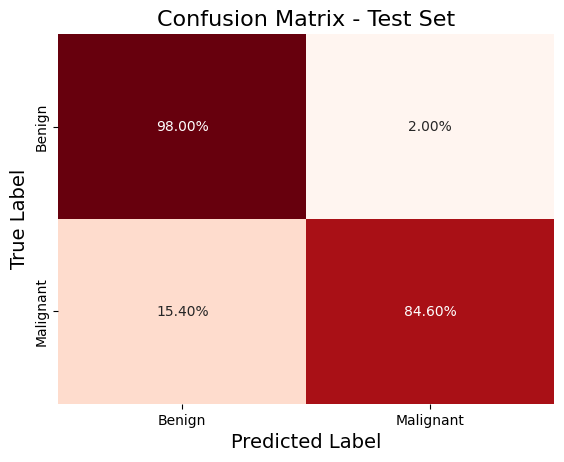

In [22]:
model.eval()
allLabels = []
allPreds = []


with torch.no_grad():
    for inputs, labels in testLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)
cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot = True, fmt = '.2%', cmap = 'Reds', xticklabels = testData.classes, yticklabels = testData.classes, cbar = False)
plt.title('Confusion Matrix - Test Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

# Prediction

In [23]:
model1 = models.efficientnet_b7(weights = 'DEFAULT')
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 1)
model1.load_state_dict(torch.load('/kaggle/working/best_model.pth',map_location=torch.device('cpu'))) 

from torchvision import transforms
from PIL import Image

image_path = "/kaggle/input/test/Benign/6299.jpg"

In [24]:
inputs.shape

torch.Size([16, 3, 170, 170])

In [25]:
# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [26]:
image = Image.open(image_path).convert("RGB")
image = valTransformer(image)

# Reshape the image to add batch dimension
image = image.unsqueeze(0) 

In [27]:
image.shape

torch.Size([1, 3, 170, 170])

In [28]:
testData.class_to_idx

{'Benign': 0, 'Malignant': 1}

In [29]:
target = ['Benign','Malignant']
with torch.no_grad():
    model1.eval()
    inputs = image.to('cpu')
    outputs = model1(inputs)
    predictions = (torch.sigmoid(outputs) > 0.5).float()
    print(target[int(predictions.item())])

Benign
